In [1]:
## import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf
keras = tf.keras
models = tf.keras.models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [4]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np

In [5]:
dataset_path= '/home/vishva/Pictures/nmld'

In [7]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
IMAGE_RES = 224
BATCH_SIZE = 16
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    '/home/vishva/Pictures/nmld',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the data will be used for testing
    subset="training",     # Specify "training" to get the training subset
    seed=42,
    label_mode='int'
)
num_examples = data.cardinality().numpy()
num_classes = len(data.class_names)

# Split the data into training and testing
testing_data = tf.keras.utils.image_dataset_from_directory(
    '/home/vishva/Pictures/nmld',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # No validation split for testing
    seed=42,
    label_mode='int',
    subset="validation"    # Specify "validation" to get the testing subset
)

Found 705 files belonging to 8 classes.
Using 564 files for training.
Found 705 files belonging to 8 classes.
Using 141 files for validation.


In [10]:
for images, labels in data.take(1):  # Take one batch from the dataset
    print(labels)
    #print(images)

tf.Tensor([0 3 0 4 5 0 1 0 3 0 7 0 6 0 2 5], shape=(16,), dtype=int32)


2024-06-17 19:04:52.232329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# Constants
IMAGE_RES = 224  # InceptionV3 input shape
BATCH_SIZE = 4

In [13]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label
train_data = data
# Define the validation split ratio
validation_split = 0.2
num_validation_samples = int(num_examples * validation_split)
validation_data = data.take(num_validation_samples)

train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_batches, validation_data=validation_batches, epochs=10)

# Evaluate the model on the testing dataset
testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(testing_batches)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Epoch 1/10


2024-06-17 19:05:06.333094: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-06-17 19:05:06.484417: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-06-17 19:05:06.531498: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.
2024-06-17 19:05:06.593853: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78452736 exceeds 10% of free system memory.
2024-06-17 19:05:06.632359: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.4037 - loss: 1.6451 - val_accuracy: 0.9196 - val_loss: 0.4275
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step - accuracy: 0.9287 - loss: 0.3710 - val_accuracy: 0.9554 - val_loss: 0.2249
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.9645 - loss: 0.2099 - val_accuracy: 0.9732 - val_loss: 0.1496
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.9862 - loss: 0.1427 - val_accuracy: 0.9732 - val_loss: 0.1076
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step - accuracy: 0.9919 - loss: 0.1039 - val_accuracy: 0.9911 - val_loss: 0.0821
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.9955 - loss: 0.0794 - val_accuracy: 0.9911 - val_loss: 0.0652
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9955 - loss: 0.0629 - val_accuracy: 0.9911 - val_loss: 0.0531
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 1.0000 - loss: 0.0513 - val_accuracy: 1.000

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,288,730 (8.73 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 20,498 (80.07 KB)

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(Epoch)
# epochs_range = range(Epoch)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss for MobileNet Model')
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


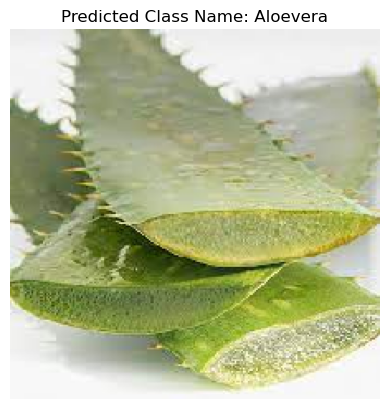

Test Accuracy: 0.9645389914512634


In [15]:
input_image_path = '/home/vishva/Pictures/nmld/Aloevera/b.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()
print("Test Accuracy:", test_accuracy)

In [ ]:
# #Chatgpt

# import tensorflow as tf
# import os

# # Check if GPU is available and set memory growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
#     except RuntimeError as e:
#         print(e)
# else:
#     print("No GPU detected. Running on CPU.")

# # Define constants
# IMAGE_RES = 224
# BATCH_SIZE = 32

# # Define the format_image function
# def format_image(image, label):
#     image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
#     return image, label

# # Load the dataset
# dataset_path = '/home/vishva/Downloads/archive/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'
# data = tf.keras.utils.image_dataset_from_directory(
#     dataset_path,
#     image_size=(IMAGE_RES, IMAGE_RES),
#     batch_size=BATCH_SIZE,
#     validation_split=0.2,  # 20% of the data will be used for testing
#     subset="training",     # Specify "training" to get the training subset
#     seed=42,
#     label_mode='int'
# )

# num_examples = data.cardinality().numpy()
# num_classes = len(data.class_names)

# # Split the dataset into training and validation
# train_data = data.skip(int(num_examples * 0.2))  # Skip the validation samples
# validation_data = data.take(int(num_examples * 0.2))  # Take the validation samples

# # Prepare the training and validation batches
# train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# # Create the base model (MobileNetV2)
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(IMAGE_RES, IMAGE_RES, 3),
#     include_top=False,
#     weights='imagenet'
# )

# # Freeze the base model
# base_model.trainable = False

# # Add custom layers for classification
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# # Create the final model
# model = tf.keras.Sequential([
#     base_model,
#     global_average_layer,
#     prediction_layer
# ])

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Train the model
# history = model.fit(train_batches, validation_data=validation_batches, epochs=10)

# # Evaluate the model on the testing dataset
# # Note: You need to define 'testing_data' similarly to how 'data' was defined
# # and split it for testing. Assuming testing_data is properly defined:
# testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_loss, test_accuracy = model.evaluate(testing_batches)
# print("Test Accuracy:", test_accuracy)
# print("Test Loss:", test_loss)


No GPU detected. Running on CPU.
Found 6900 files belonging to 80 classes.
Using 5520 files for training.
Epoch 1/10


Corrupt JPEG data: premature end of data segment
2024-06-16 22:21:57.685411: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-06-16 22:21:57.863802: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


  1/139 ━━━━━━━━━━━━━━━━━━━━ 19:25 8s/step - accuracy: 0.0000e+00 - loss: 4.7355

2024-06-16 22:21:59.138259: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-06-16 22:21:59.323251: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


  2/139 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.0000e+00 - loss: 4.6566 

2024-06-16 22:22:00.590004: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


 66/139 ━━━━━━━━━━━━━━━━━━━━ 57s 790ms/step - accuracy: 0.1122 - loss: 4.1718

In [16]:
# Save the model
model.save('my_model.h5')


In [17]:
# Load the model
loaded_model = tf.keras.models.load_model('my_model.h5')

# Verify the loaded model
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,234 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [18]:
import IPython
import os

# Function to create a download link
def create_download_link(file_path):
    from IPython.display import FileLink
    return FileLink(file_path)

# Display the download link
display(create_download_link('my_model.h5'))


/home/vishva/Desktop/my_model.h5